# 1. Import modules

In [55]:
%load_ext autoreload

%autoreload 2
import time

import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer import Link, Chain, ChainList

from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

from chainer import datasets, iterators, optimizers, serializers
from chainer import Function, report, training, utils, Variable

import numpy
import os
import glob
import sys
from pathlib import Path
import matplotlib.pyplot as plt

from chainer import Sequential
import easy_chainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Define of structure
## MLP_01 : MLP, dropout=None, Batch_Normalization=None
## MLP_02 : MLP, Dropout, Batch_Normalization

In [56]:
class MLP_01(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP_01, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out
            
           
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [73]:
# 4層NN(入力→中間，中間→出力)
class MLP_02(chainer.Chain):
    
    """
    モデルの実装
    """

    def __init__(self, n_units, n_out, train=True, drop_out_ratio=0.3):
        super(MLP_02, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out
    
        # 学習の場合：True
        self.__train = train
        # drop outの実施有無
        self.__drop_out = True
        # drop outの比率
        self.drop_out_ratio = drop_out_ratio
    

    def __call__(self, x):
        drop_out = self.__train and self.__drop_out 
        h1 = F.dropout(F.relu(self.l1(x)), ratio=self.drop_out_ratio)
        h2 = F.dropout(F.relu(self.l2(h1)), ratio=self.drop_out_ratio)
        return self.l3(h2)
    
    
    # 学習の場合；True
    def __get_train(self):
        return self.__train
    
    def __set_train(self, train):
        self.__train = train
        
    train = property(__get_train, __set_train)
    
    # Dropoutを使用する場合：True
    def __get_drop_out(self):
        return self.__drop_out
    
    def __set_drop_out(self, drop_out):
        '''
        drop outフラグの設定
        '''
        self.__drop_out = drop_out
    
    drop_out = property(__get_drop_out, __set_drop_out)

def parse_device(args):
    gpu = None
    if args.gpu is not None:
        gpu = args.gpu
    elif re.match(r'(-|\+|)[0-9]+$', args.device):
        gpu = int(args.device)

    if gpu is not None:
        if gpu < 0:
            return chainer.get_device(numpy)
        else:
            import cupy
            return chainer.get_device((cupy, gpu))

    return chainer.get_device(args.device)

# 3. Import datasets

In [70]:
# 1,000datas
data, teach = easy_chainer.load_Data("C:/Users/Owner/Desktop/Normalized/val/val_ebina_day1.xlsx")
data = data.astype(numpy.float32)
teach = teach
print(teach)
print(teach.shape)

[102. 104.  97. 188. 197. 199. 194. 184. 184. 167. 176. 167. 177. 158.
 148. 136. 132. 136. 147.  98.  85.]
(21,)


C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = xls.as_matrix()[:-1]
C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  teach = xls.as_matrix()[-1]


In [71]:
# 回帰させるときに必要（分類はint型）
teach = teach.astype(numpy.float32)

In [59]:
data.shape

(1000, 21)

In [6]:
id_all = numpy.arange(1, len(teach) + 1, 1).astype(numpy.int32) - 1
# print(id_all)

In [31]:
numpy.random.seed(11)
id_train = numpy.random.choice(id_all, 400, replace=False) #重複なし
print(id_train)

[201 384 179 351 259 342 212 180 117 390 377 216 214 312 270 268  74 235
 356 421 104 182  60 393 345 190 331 173 234 144  20 174  57 101 295 129
 350 282 247 218 369 401 184 162 165  21  14  39  56 230 232 347 137 255
 205 113 394 308  31 416 262 353 228 189 158 415 146 396 373  70 238 292
 153 418 221 329 170 358 281  54 340  55 403 414  41  16 204 200 383 260
 199 323 365  88 251 346 316 124 288 155  26  44  49 250  83  11 367   4
 139 319 210  12 425 285  87 381  53 307  61 175 279 196 198 169 135 102
 318 136  28 374 106 302 186 320 143  82  52 134 130 150  98 343 310 271
 229 239 105 317 203 412 103 207  77   8   2 274 195 202  25 375 387 290
  50  85 159 164 352  22  62 378  99  69 408 289 188 240 256  95 151 411
  29 243 296 419 391 211 197 398 116  86 368 123  46   3 112 183  30 154
 422  94 402 389  51  36  97 219  13 163  58 237 336 258 299 267 324   9
 265 128 372  78  45 115 348 157  24 349 284 233 266 126 355 286 354  33
 294 122 220  63 277  66 194 177 206 127 291 424 25

In [32]:
id_test = numpy.delete(id_all, id_train)
print(id_test)

[ 34  37  71  80  81  91  92 109 125 140 161 176 191 231 236 253 269 280
 301 330 332 337 338 385 388 409 423]


In [33]:
# train, test データをExcelに保存するスクリプト
# このスクリプトを追加する

teach_train = teach[id_train]
df_teach = pandas.DataFrame(teach_train, columns=['train'])
df_idtrain = pandas.DataFrame(id_train, columns=['id_train'])
df_train = pandas.concat([df_idtrain, df_teach], axis=1)
# print(df_train)

teach_test = teach[id_test]
df_id_test = pandas.DataFrame(teach_test, columns=['test'])
df_idtest = pandas.DataFrame(id_test, columns=['id_test'])
df_test = pandas.concat([df_idtest, df_id_test], axis=1)
# print(df_test)

df = pandas.concat([df_train, df_test], axis=1)
df.to_excel("C:/Users/Owner/Desktop/Normalized/blood_glucose_teach_20191107_01.xlsx")
# print(df)

In [72]:
m = 11

x_train, y_train = data[:, 0:m], teach[0:m]
x_test, y_test = data[:, m:22], teach[m:22]

print(y_train.shape, y_train[1])
print(y_test.shape, y_test[1])

(11,) 104.0
(10,) 177.0


# 4. Separate datas

In [61]:
x_train, y_train = data[:, id_train], teach[id_train]
x_test, y_test = data[:, id_test], teach[id_test]

NameError: name 'id_train' is not defined

# 5. Generate of iterator

In [74]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1,1 ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, 1))

train_iter = chainer.iterators.SerialIterator(train, 3, repeat=True, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, 3, repeat=False, shuffle=False)

# 6. Define of models
## 6.1 model determination 

In [76]:
net = MLP_02(1000,1)
model = L.Classifier(net,
                     lossfun=F.mean_squared_error,
                     accfun = F.r2_score)
model.compute_accuracy = False""

## 6.2 define of optimizer

In [77]:
# 最適化方法
#optimizer = chainer.optimizers.SGD()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# 7. Trainer
## define of updater

In [78]:
updater = training.updaters.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (500, 'epoch'), out="Result2018_oono/%s" % time.strftime("%Y%m%d%H%M%S"))

## 7.2 Option determination

In [79]:
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


## 7.3 Start of training

In [80]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           23972.4     10958.2                                                        0.348163      
2           13228.6     1205.59                                                        0.815024      
3           2866.77     7600.91                                                        1.24207       
4           5547.4      8855.98                                                        1.78456       
5           3142.56     1520.39                                                        2.3771        
6           2475.8      808.071                                                        2.74854       
7           2745.01     820.755                                                        3.16305       
8           2146.7      1665.14                                                        3.66469       
9           1178.25     3387.72                                                     

76          740.264     1054.64                                                        34.9316       
77          640.258     1294.91                                                        35.3574       
78          373.035     1710.19                                                        35.7739       
79          739.958     1191.44                                                        36.2642       
80          508.522     1060.26                                                        36.8182       
81          565.277     1029.67                                                        37.3705       
     total [########..........................................] 16.36%
this epoch [########################################..........] 81.82%
       300 iter, 81 epoch / 500 epochs
    7.9164 iters/sec. Estimated time to finish: 0:03:13.689994.
82          396.964     1168.74                                                        37.8213       
83          597.515     1288.98          

150         416.267     987.776                                                        66.0843       
151         367.017     974.228                                                        66.5487       
152         199.022     1011.12                                                        66.9468       
153         442.06      976.94                                                         67.2687       
154         480.936     1028.87                                                        67.701        
155         329.952     1249.01                                                        68.2801       
156         679.984     997.006                                                        68.8793       
157         410.098     1055.21                                                        69.4987       
158         351.216     1044.59                                                        70.1461       
159         446.067     958.377                                                   

224         91.9443     1003.15                                                        106.917       
225         296.019     996.376                                                        107.785       
226         344.675     1059.62                                                        108.749       
227         183.865     1062.38                                                        109.654       
228         409.378     1010.89                                                        111.027       
229         378.619     911.528                                                        111.954       
230         194.374     932.487                                                        112.517       
231         215.524     897.751                                                        112.949       
232         248.554     961.061                                                        113.497       
233         315.871     887.316                                                   

300         285.538     842.851                                                        151.892       
     total [##############################....................] 60.00%
this epoch [..................................................]  0.00%
      1100 iter, 300 epoch / 500 epochs
    7.1667 iters/sec. Estimated time to finish: 0:01:42.325718.
301         458.169     937.74                                                         152.353       
302         322.906     979.362                                                        152.808       
303         303.462     922.085                                                        153.208       
304         169.246     1021.53                                                        153.768       
305         182.108     875.349                                                        154.242       
306         329.007     1076.45                                                        154.611       
307         152.744     966.93          

374         285.204     885.336                                                        192.642       
375         621.043     1057.59                                                        193.058       
376         334.789     894.654                                                        193.531       
377         270.658     857.018                                                        193.993       
378         191.052     1370.76                                                        194.441       
379         524.572     860.972                                                        194.957       
380         348.789     875.865                                                        195.418       
381         219.452     1159.13                                                        195.856       
     total [######################################............] 76.36%
this epoch [########################################..........] 81.82%
      1400 iter, 381 epoch / 500 epochs
  

448         309.208     1028.99                                                        237.461       
449         384.637     929.627                                                        238.367       
450         453.844     865.413                                                        239.033       
451         220.949     1634.36                                                        239.867       
452         581.435     850.029                                                        240.783       
453         476.093     949.481                                                        241.67        
454         241.769     970.228                                                        242.462       
455         162.39      2081.2                                                         243.306       
456         980.74      843.929                                                        244.009       
457         888.225     1095.57                                                   

# 8. Varidation

## 8.1 Varidatiom of training data

In [86]:
# 検証（訓練データ）
# train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(3):
    cal_ref = train_ref[i]
    cal_pred = net(train_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d " % (cal_ref, cal_pred))

Ref: 167, Pred: 155 
Ref: 176, Pred: 161 
Ref: 102, Pred: 97 


In [28]:
# 参考用の相関係数
tarr_ref = numpy.array([169, 97, 103, 188, 203, 160, 129, 150, 119, 111])
tarr_pre = numpy.array([179, 88, 121, 182, 179, 154, 114, 97, 101, 110])
print(tarr_ref.shape, tarr_pre.shape)

tcor = numpy.corrcoef(tarr_ref, tarr_pre)[0, 1]
print(tcor)

(10,) (10,)
0.8606246021279896


In [ ]:
# ガチなほうの相関係数
tarr_ref = numpy.array([169, 97, 103, 188, 203, 160, 129, 150, 119, 111])
tarr_pre = numpy.array([179, 88, 121, 182, 179, 154, 114, 97, 101, 110])
print(tarr_ref.shape, tarr_pre.shape)

tcor = numpy.corrcoef(tarr_ref, tarr_pre)[0, 1]
print(tcor)

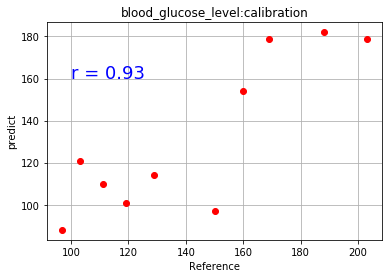

In [32]:
plt.plot(tarr_ref, tarr_pre, 'ro')
plt.grid()
plt.xlabel('Reference')
plt.ylabel('predict')
plt.title('blood_glucose_level:calibration')
plt.text(100,160, 'r = 0.93', fontsize=18, color='b')
plt.savefig('val_result')
plt.show()

## 8.2 Varidation of test data

In [90]:
# 検証（テストデータ）
# test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(3):
    ref = test_ref[i]
    pred = net(test_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d " % (ref, pred))


Ref: 85, Pred: 114 


IndexError: index 1 is out of bounds for axis 0 with size 1

In [34]:
arr_train = numpy.array([97, 222, 109, 165, 205, 172, 167, 142, 160, 103])
arr_test = numpy.array([100, 187, 115, 184, 164, 193, 148, 151, 153, 102])

cor = numpy.corrcoef(arr_train, arr_test)[0, 1]
print(cor)

0.8648281590142726


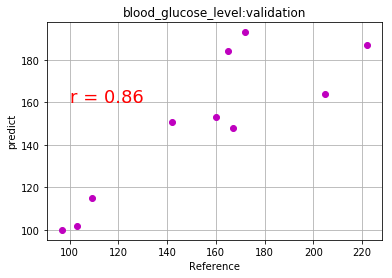

In [35]:
plt.plot(arr_train, arr_test, 'mo')
plt.grid()
plt.xlabel('Reference')
plt.ylabel('predict')
plt.title('blood_glucose_level:validation')
plt.text(100,160, 'r = 0.86', fontsize=18, color='r')
plt.savefig('val_result')
plt.show()